## Dash para COVID

En el presente trabajo se analizarán los datos de COVID-19 que se obtienen a partir de la declaración de los casos a la Red Nacional de Vigilancia Epidemiológica (RENAVE) a través de la plataforma informática via Web SiViES (Sistema de Vigilancia de España) que gestiona el Centro nacional de Epidemología (CNE). Estos datos corresponden al periodo comprendido entre el inicio de la pandemaia (enero-2020) hasta 28 de marzo de 2022.

Para realizar algunos cálculos más específicos utilizaremos datos del INE, específicamente de población por provincia y franja etaria de los últimos tres años (2020,2021 y 2022) y los datos de polígonos que corresponden a las representaciones gráficas de las provincias de España.

<b> Para empezar, importamos las librerías que utilizaremos para este análisis. </b>

In [94]:
# Importación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import date
from datetime import datetime
import plotly.express as px
import plotnine
from plotnine import *
import dash
from dash import dcc, html
import plotly.graph_objects as go
import folium

### Lectura de dataset 

Realizamos la lectura de los datasets de Covid y provincias y realizamos unos primeros ajustes a los mismos.

In [95]:
covid = pd.read_csv('Datos/casos_hosp_uci_def_sexo_edad_provres.csv')

In [96]:
prv = pd.read_csv('Datos/provinces_es.csv')
geo_prv = 'Datos/SP_provincias.geojson'
map = gpd.read_file(geo_prv)

In [97]:
geo_prv = open('Datos/SP_provincias.geojson', encoding='UTF-8')
map2 = gpd.read_file(geo_prv)

In [98]:
prv

,code,postal_code,name,phone_code,iso2
0,VI,1,Álava,945,ES
1,AB,2,Albacete,967,ES
2,A,3,Alacant,950,ES
3,AL,4,Almería,920,ES
4,AV,5,Ávila,924,ES
5,BA,6,Badajoz,924,ES
6,PM,7,Illes Balears,971,ES
7,B,8,Barcelona,93,ES
8,BU,9,Burgos,947,ES
9,CC,10,Cáceres,927,ES


In [99]:
map['postal_code'] = pd.to_numeric(map['CC_2'])
map.drop(['CC_2','NAT2018'],axis='columns',inplace=True)
map.rename(columns={'NAME_1':'comunidad_autonoma',
                   'NAME_2':'provincia'},inplace=True)

Realizamos una pre-visualziación

In [100]:
covid.head()

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def
0,A,H,0-9,2020-01-01,0,0,0,0
1,A,H,10-19,2020-01-01,0,0,0,0
2,A,H,20-29,2020-01-01,0,0,0,0
3,A,H,30-39,2020-01-01,0,0,0,0
4,A,H,40-49,2020-01-01,0,0,0,0


In [101]:
prv.head()

,code,postal_code,name,phone_code,iso2
0,VI,1,Álava,945,ES
1,AB,2,Albacete,967,ES
2,A,3,Alacant,950,ES
3,AL,4,Almería,920,ES
4,AV,5,Ávila,924,ES


In [102]:
map.head()

,comunidad_autonoma,provincia,geometry,postal_code
0,Andalucía,Almería,"MULTIPOLYGON (((-3.03042 35.94236, -3.03042 35...",4
1,Andalucía,Cádiz,"MULTIPOLYGON (((-6.21958 36.3811, -6.21958 36....",11
2,Andalucía,Córdoba,"MULTIPOLYGON (((-5.04854 37.6369, -5.04667 37....",14
3,Andalucía,Granada,"MULTIPOLYGON (((-3.35014 36.72952, -3.35014 36...",18
4,Andalucía,Huelva,"MULTIPOLYGON (((-6.83648 37.11547, -6.83643 37...",21


Empezamos uniendo nuestros datasets de covid y provincias

In [103]:
cov_prv = covid.merge(prv,
                      how = 'left',
                      left_on = 'provincia_iso',
                      right_on = 'code',
                      suffixes= ('_cov','_prv')
)

Realizamos algunos formateos a los datos, para que nos ayuden en las visualizaciones posteriores

In [104]:
cov_prv.head()

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def,code,postal_code,name,phone_code,iso2
0,A,H,0-9,2020-01-01,0,0,0,0,A,3.0,Alacant,950.0,ES
1,A,H,10-19,2020-01-01,0,0,0,0,A,3.0,Alacant,950.0,ES
2,A,H,20-29,2020-01-01,0,0,0,0,A,3.0,Alacant,950.0,ES
3,A,H,30-39,2020-01-01,0,0,0,0,A,3.0,Alacant,950.0,ES
4,A,H,40-49,2020-01-01,0,0,0,0,A,3.0,Alacant,950.0,ES


In [105]:
cov_prv['periodo'] = cov_prv['fecha'].str.slice(0, 4)
cov_prv['periodo'] = pd.to_numeric(cov_prv['periodo'])
cov_prv['fecha'] = pd.to_datetime(covid['fecha'], 
                                  format = '%Y-%m-%d', 
                                  errors = 'coerce')
cov_prv['semana'] = cov_prv['fecha'].dt.isocalendar().week
cov_prv.drop(['name', 'phone_code', 'iso2'], 
             axis = 'columns', 
             inplace=True)
cov_prv.rename(columns={'grupo_edad': 'franja_etaria'}, 
               inplace=True)
cov_prv.head()

,provincia_iso,sexo,franja_etaria,fecha,num_casos,num_hosp,num_uci,num_def,code,postal_code,periodo,semana
0,A,H,0-9,2020-01-01,0,0,0,0,A,3.0,2020,1
1,A,H,10-19,2020-01-01,0,0,0,0,A,3.0,2020,1
2,A,H,20-29,2020-01-01,0,0,0,0,A,3.0,2020,1
3,A,H,30-39,2020-01-01,0,0,0,0,A,3.0,2020,1
4,A,H,40-49,2020-01-01,0,0,0,0,A,3.0,2020,1


Realizamos la importación de los datos de población de cada provincia, correspondientes a los años 2021, 2021 y 2022.

Luego, unimos las tres fuentes en un único dataset.

In [106]:
pob_esp2020 = pd.read_csv('Datos/PoblacionEspana-Provincia_2020.csv', 
                      sep=';', 
                      encoding='latin-1')
pob_esp2021 = pd.read_csv('Datos/PoblacionEspana-Provincia_2021.csv', 
                      sep=';', 
                      encoding='latin-1')
pob_esp2022 = pd.read_csv('Datos/PoblacionEspana-Provincia_2022.csv', 
                      sep=';', 
                      encoding='latin-1')
pob_esp = pd.concat([pob_esp2020, pob_esp2021, pob_esp2022])
pob_esp.head(3)

,Edad Simple,Provincias,Sexo,Periodo,Total
0,0 años,02 Albacete,Hombres,1 de julio de 2020,"1.475,500000"
1,0 años,02 Albacete,Mujeres,1 de julio de 2020,"1.352,500000"
2,0 años,03 Alicante/Alacant,Hombres,1 de julio de 2020,"6.962,000000"


A continuación, realizamos algunos formateos al dataset para dejarlo a punto para el análisis

In [107]:
pob_esp.rename(columns={'Edad Simple': 'edad', 
                        'Provincias': 'provincia', 
                        'Sexo':'sexo', 
                        'Periodo':'periodo', 
                        'Total':'total'}, 
               inplace=True)

In [108]:
pob_esp['total'] = pob_esp['total'].str.replace(',','|')
pob_esp['total'] = pob_esp['total'].str.replace('.','')
pob_esp['total'] = pob_esp['total'].str.replace('|','.')
pob_esp['total'] = pob_esp['total'].astype(float)

In [109]:
pob_esp['postal_code'] = pob_esp['provincia'].str.slice(0, 2)
pob_esp['postal_code'] = pd.to_numeric(pob_esp['postal_code'])

In [110]:
pob_esp.loc[pob_esp['sexo'] == 'Hombres', 'sexo'] = 'H'
pob_esp.loc[pob_esp['sexo'] == 'Mujeres', 'sexo'] = 'M'

In [111]:
datos = pob_esp['edad'].str.split(expand=True)
datos.columns = ['edad2', 'edad3', 'edad4', 'edad5']
pob_esp = pd.concat([pob_esp, datos], axis=1)
pob_esp.drop(['edad3', 'edad4', 'edad5'], axis = 'columns', inplace=True)
pob_esp['edad2'] = pd.to_numeric(pob_esp['edad2'])
pob_esp.head(3)

,edad,provincia,sexo,periodo,total,postal_code,edad2
0,0 años,02 Albacete,H,1 de julio de 2020,1475.5,2,0
1,0 años,02 Albacete,M,1 de julio de 2020,1352.5,2,0
2,0 años,03 Alicante/Alacant,H,1 de julio de 2020,6962.0,3,0


In [112]:
def franja_etaria(edad):
    if edad < 10:
        franja = '0-9'
    elif edad < 20:
        franja = '10-19'
    elif edad < 30:
        franja = '20-29'
    elif edad < 40:
        franja = '30-39'
    elif edad < 50:
        franja = '40-49'
    elif edad < 60:
        franja = '50-59'
    elif edad < 70:
        franja = '60-69'
    elif edad < 80:
        franja = '70-79'
    else:
        franja = '80+'
    return franja

In [113]:
pob_esp['franja_etaria'] = pob_esp['edad2'].apply(franja_etaria)

In [114]:
separado = pob_esp['periodo'].str.split(' ', expand=True)
pob_esp['periodo']= separado[4]
pob_esp['periodo'] = pd.to_numeric(pob_esp['periodo'])
pob_esp.head(3)

,edad,provincia,sexo,periodo,total,postal_code,edad2,franja_etaria
0,0 años,02 Albacete,H,2020,1475.5,2,0,0-9
1,0 años,02 Albacete,M,2020,1352.5,2,0,0-9
2,0 años,03 Alicante/Alacant,H,2020,6962.0,3,0,0-9


A continuación, agrupamos los datos de población por año y provicnia, para cruzarlo con nuestro dataset de casos de covid

In [115]:
poblacion = pob_esp.groupby(['periodo', 
                             'provincia', 
                             'postal_code', 
                            ]).agg({'total':'sum'}).reset_index()
poblacion.head()

,periodo,provincia,postal_code,total
0,2020,01 Araba/Álava,1,3.301570e+05
1,2020,02 Albacete,2,3.890275e+05
2,2020,03 Alicante/Alacant,3,1.889768e+06
3,2020,04 Almería,4,7.171430e+05
4,2020,05 Ávila,5,1.580949e+05


#### Incidencia Acumulada a 14 dás por cada 100.000 habitantes

In [116]:
sum_cov = cov_prv.groupby(['fecha', 'periodo']).agg({'num_casos':'sum'})

In [117]:
def buildLaggedFeatures(s, lag=2, dropna=True):
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            for l in range(1,lag+1):
                new_dict['%s_%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['_%d' %i for i in the_range]
    else:
        print ('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

In [118]:
casos_trend = buildLaggedFeatures(sum_cov,lag=13,dropna=False)

In [119]:
casos_trend = casos_trend.reset_index()

In [120]:
casos_trend2 = pd.melt(casos_trend, 
                       id_vars=['fecha', 'periodo'], 
                       value_vars=['num_casos', 'num_casos_1', 'num_casos_2','num_casos_3', 'num_casos_4', 
                                   'num_casos_5', 'num_casos_6', 'num_casos_7', 'num_casos_8', 'num_casos_9', 
                                   'num_casos_10', 'num_casos_11', 'num_casos_12', 'num_casos_13'])

In [121]:
casos_trend2 = casos_trend2.groupby(['fecha', 'periodo']).agg({'value':'sum'}).reset_index()
pob = poblacion.groupby(['periodo']).agg({'total':'sum'}).reset_index()
casos_trend_pob = casos_trend2.merge(pob, how='left', left_on='periodo', right_on='periodo')
casos_trend_pob['ia14d'] = casos_trend_pob['value']/casos_trend_pob['total']*100000
casos_trend_pob.head()

,fecha,periodo,value,total,ia14d
0,2020-01-01,2020,0.0,4.735568e+07,0.0
1,2020-01-02,2020,0.0,4.735568e+07,0.0
2,2020-01-03,2020,0.0,4.735568e+07,0.0
3,2020-01-04,2020,0.0,4.735568e+07,0.0
4,2020-01-05,2020,0.0,4.735568e+07,0.0


Visualizamos la tendencia de la IA

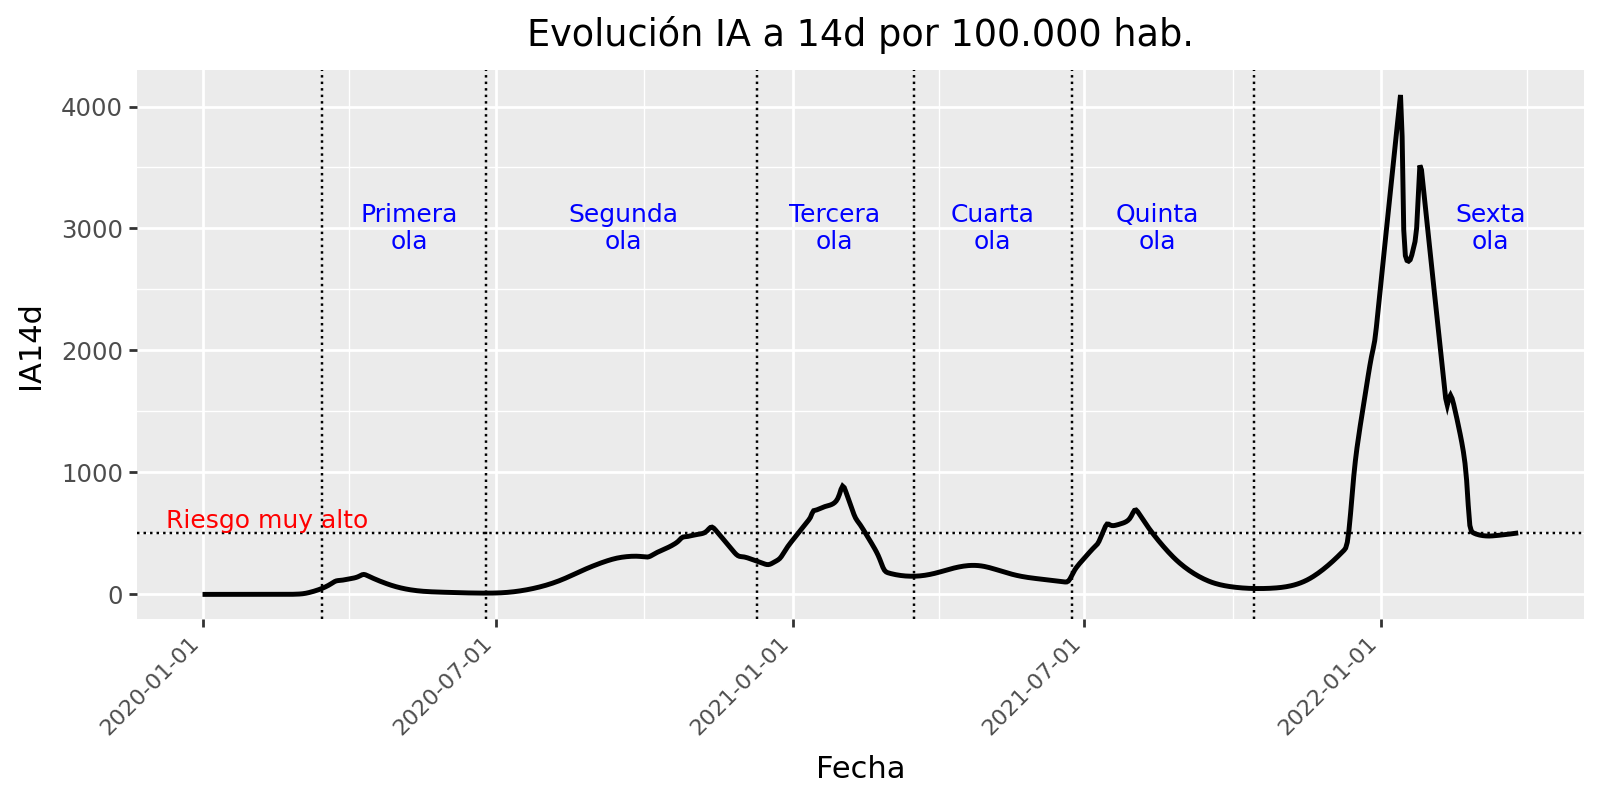

In [122]:
(
    ggplot(casos_trend_pob)  
    + aes(x = 'fecha', 
          y = 'ia14d')   
    #+ geom_rect(data=df, mapping=aes(xmin=df.x1, xmax=df.x2, ymin=0, ymax=80000, fill=df.r), color="black", alpha=0.5)
    + geom_smooth(method = "lowess", 
                  span = 0.05)

    #+ geom_hline(yintercept = 500, size = 0.5, linetype = 'dotted')
    + geom_hline(yintercept = 500, size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2020-03-15', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2020-06-25', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2020-12-10', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2021-03-17', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2021-06-23', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2021-10-14', size = 0.5, linetype = 'dotted')
    + theme(figure_size=(8, 4),
            axis_text_x = element_text(angle = 45,
                                      hjust = 1,
                                      size = 8))
    + annotate('text', x='2020-02-10', y=600, label='Riesgo muy alto', size=9, color='red')
    + annotate('text', x='2020-05-08', y=3000, label='Primera\nola', size=9, color='blue')
    + annotate('text', x='2020-09-18', y=3000, label='Segunda\nola', size=9, color='blue')
    + annotate('text', x='2021-01-27', y=3000, label='Tercera\nola', size=9, color='blue')
    + annotate('text', x='2021-05-05', y=3000, label='Cuarta\nola', size=9, color='blue')
    + annotate('text', x='2021-08-15', y=3000, label='Quinta\nola', size=9, color='blue')
    + annotate('text', x='2022-03-10', y=3000, label='Sexta\nola', size=9, color='blue')
    + labs(title='Evolución IA a 14d por 100.000 hab.', x='Fecha', y='IA14d')
)


Se visualizan picos en determinados momentos de la pandemia, que corresponden a las diferentes olas, notándose especialmente la correspondiente a la sexta ola de la pandemia.

A continuación, incluimos un gráfico interactivo para visualizar la tendencia de casos por provincia.

In [123]:
prv_trend = cov_prv.merge(map,
                          how='left',
                          left_on='postal_code',
                          right_on='postal_code')
prv_trnd = prv_trend.groupby(['provincia','fecha']).agg({'num_casos':'sum'}).reset_index()

prv_trend['fecha'] = pd.to_datetime(prv_trnd['fecha'],
                                    format = '%Y-%m-%d',
                                    errors = 'coerce')

df_sp = prv_trnd.groupby(['fecha']).agg({'num_casos':'sum'}).reset_index()
df_sp['provincia'] = 'ALL'
df_dash = pd.concat([prv_trnd, df_sp])
available_prv = df_dash['provincia'].unique()

In [124]:
app = dash.Dash()

In [125]:
available_prv

array(['A Coruña', 'Albacete', 'Alicante', 'Almería', 'Asturias',
       'Badajoz', 'Baleares', 'Barcelona', 'Burgos', 'Cantabria',
       'Castellón', 'Ciudad Real', 'Cuenca', 'Cáceres', 'Cádiz',
       'Córdoba', 'Girona', 'Granada', 'Guadalajara', 'Guipúzcoa',
       'Huelva', 'Huesca', 'Jaén', 'La Rioja', 'Las Palmas', 'León',
       'Lleida', 'Lugo', 'Madrid', 'Murcia', 'Málaga', 'Navarra',
       'Ourense', 'Palencia', 'Pontevedra', 'Salamanca',
       'Santa Cruz de Tenerife', 'Segovia', 'Sevilla', 'Soria',
       'Tarragona', 'Teruel', 'Toledo', 'Valencia', 'Valladolid',
       'Vizcaya', 'Zamora', 'Zaragoza', 'Álava', 'Ávila', 'ALL'],
      dtype=object)

In [126]:
app.layout = html.Div([
    dcc.Dropdown(
        id='demo-dropdown',
        options = [{'label':k,'value':k} for k in available_prv],
        value = ['All'],
        multi = True
    ),

    html.Hr(),
    dcc.Graph(id='display-selected-values'),
])

In [127]:
@app.callback(
    dash.dependencies.Output('display-selected´values','figure'),
    [dash.dependencies.Input('demo-dropdown','value')])

def updatte_output (value):
    ts = df_dash(df_dash['provinica'].isin(value))
    fig = px.line(ts,
                  x = 'fecha',
                  y = 'num_casos',
                  color = 'provincia',
                  line_shape='spline')
    
    return fig

In [128]:
if __name__ == '__main__':
    app.run(port=8076)